In [1]:
import wntr
import wntr.network.controls as controls
import csv
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import numpy as np

In [2]:
########## Simulation parameters ##########
file_path = "ctown_map_with_controls.inp"
wntr_simulation = True
simulation_days = 1

wntr_node_results_path =  "ctown_wntr_node_results.csv"
wntr_results_results_path = "ctown_wntr_results_results.csv"

epanet_node_results_path =  "ctown_epanet_node_results.csv"
epanet_results_results_path = "ctown_epanet_results_results.csv"

if wntr_simulation == True:
    output_node_path = wntr_node_results_path
    output_results_path = wntr_results_results_path
else:
    output_node_path = epanet_node_results_path
    output_results_path = epanet_results_results_path

In [3]:
def get_node_list_by_type(a_list, a_type):
    result = []
    for node in a_list:
        if wn.get_node(node).node_type == a_type:
            result.append(str(node))
    return result

def get_link_list_by_type(a_list, a_type):
    result = []
    for link in a_list:
        if wn.get_link(link).link_type == a_type:
            result.append(str(link))
    return result

def create_node_header(a_list):
    result = []
    for node in a_list:
        result.append(node + "_LEVEL")
    return result

def create_link_header(a_list):
    result = []
    for link in a_list:
        result.append(link + "_FLOW")
        result.append(link + "_STATUS")
    return result

def register_epanet_results(pressure_results, flowrate_results, status_results, timestamp):
    some_values_list = []
    some_values_list.extend([timestamp])
        
    # Results are divided into: nodes: reservoir and tanks, links: flows and status
    # Get tanks levels
    for tank in tank_list:
        some_values_list.extend([pressure_results[tank]])
    
    for junction in junction_list:
        some_values_list.extend([pressure_results[junction]])

    # Get pumps flows and status
    for pump in pump_list:    
        some_values_list.extend([flowrate_results[pump]])
        some_values_list.extend([status_results[pump]])

    # Get valves flows and status
    for valve in valve_list:
        some_values_list.extend([flowrate_results[valve]])
        some_values_list.extend([status_results[valve]])    
    return some_values_list
    
def register_wntr_results(results):    
    some_values_list = []
    some_values_list.extend([results.timestamp])

    # Results are divided into: nodes: reservoir and tanks, links: flows and status
    # Get tanks levels
    for tank in tank_list:
        some_values_list.extend([wn.get_node(tank).level])
    
    if wntr_simulation == True:
        # Get junction  levels
        for junction in junction_list:
            some_values_list.extend([wn.get_node(junction).head - wn.get_node(junction).elevation])

    # Get pumps flows and status
    for pump in pump_list:

        some_values_list.extend([wn.get_link(pump).flow])

        if type(wn.get_link(pump).status) is int:
            some_values_list.extend([wn.get_link(pump).status])
        else:
            some_values_list.extend([wn.get_link(pump).status.value])

    # Get valves flows and status
    for valve in valve_list:
        some_values_list.extend([wn.get_link(valve).flow])

        if type(wn.get_link(valve).status) is int:
            some_values_list.extend([wn.get_link(valve).status])
        else:
            some_values_list.extend([wn.get_link(valve).status.value])

    return some_values_list

def write_results(results, path):
    with open(path, 'w', newline="") as f:
        writer = csv.writer(f)
        writer.writerows(results)

In [4]:
######################################## init ####################################
inp_file = file_path
wn = wntr.network.WaterNetworkModel(inp_file)

### Demand and tank init levels parameters ######
week_index = 0
limit = (simulation_days * 24) - 1

demand_patterns_path = "../Demand_patterns/three_year_demands_ctown.csv"
starting_demand_path = "../Demand_patterns/starting_demand_points.csv"
initial_tank_levels_path = "../Demand_patterns/tank_initial_conditions.csv"

total_demands = pd.read_csv(demand_patterns_path, index_col=0)
demand_starting_points = pd.read_csv(starting_demand_path, index_col=0)
initial_tank_levels = pd.read_csv(initial_tank_levels_path, index_col=0)
week_start = demand_starting_points.iloc[week_index][0]
week_demands = total_demands.loc[week_start:week_start + limit, :]

for name, pat in wn.patterns():
    pat.multipliers = week_demands[name].values.tolist()

for i in range(1, 8):
    wn.get_node('T' + str(i)).init_level = \
        float(initial_tank_levels.iloc[week_index]['T' + str(i)])

node_list = list(wn.node_name_list)
link_list = list(wn.link_name_list)

tank_list = get_node_list_by_type(node_list, 'Tank')
junction_list = get_node_list_by_type(node_list, 'Junction')
pump_list = get_link_list_by_type(link_list, 'Pump')
valve_list = get_link_list_by_type(link_list, 'Valve')

list_header = ["Timestamps"]
aux = create_node_header(tank_list)
list_header.extend(aux)

aux = create_node_header(junction_list)
list_header.extend(aux)

aux = create_link_header(pump_list)
list_header.extend(aux)
list_header.extend(aux)

aux = create_link_header(valve_list)
list_header.extend(aux)

results_list = []
results_list.append(list_header)

C:\ProgramData\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning:

Not all curves were used in "ctown_map_with_controls.inp"; added with type None, units conversion left to user



In [ ]:
################################### simulation ###################################
sim_results_list = []
sim_results_list.append(list_header)

if wntr_simulation == True:
    sim = wntr.sim.WNTRSimulator(wn, mode='PDD')
else:
    sim = wntr.sim.EpanetSimulator(wn)
    
wn.options.time.duration = wn.options.time.hydraulic_timestep
master_time = 0

iteration_limit = (simulation_days * 24 * 3600) / wn.options.time.hydraulic_timestep
while master_time <= iteration_limit:    
    if wntr_simulation == True:    
        results = sim.run_sim(convergence_error=True)
    else:
        results = sim.run_sim()

    if not results.time:
        pass    
    else:        
        values_list = register_wntr_results(results)        
        results_list.append(values_list)    

        if master_time == 0 and len(results.node['pressure']) > 1:
            these_pressure_results = results.node['pressure'].iloc[0]
            these_flowrate_results = results.link['flowrate'].iloc[0]
            these_status_results = results.link['status'].iloc[0]
            epanet_values_list = register_epanet_results(these_pressure_results, these_flowrate_results, these_status_results, results.timestamp)
            sim_results_list.append(epanet_values_list)

            these_pressure_results = results.node['pressure'].iloc[1]
            these_flowrate_results = results.link['flowrate'].iloc[1]
            these_status_results = results.link['status'].iloc[1]
            epanet_values_list = register_epanet_results(these_pressure_results, these_flowrate_results, these_status_results, results.timestamp)
            sim_results_list.append(epanet_values_list)
        if results.time:
            these_pressure_results = results.node['pressure'].iloc[0]
            these_flowrate_results = results.link['flowrate'].iloc[0]
            these_status_results = results.link['status'].iloc[0]
            epanet_values_list = register_epanet_results(these_pressure_results, these_flowrate_results, these_status_results, results.timestamp)
            sim_results_list.append(epanet_values_list)
    master_time +=1

C:\ProgramData\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning:

Not all curves were used in "ctown_map_with_controls.inp"; added with type None, units conversion left to user



In [8]:
############################## simulation output ################################
write_results(results_list, output_node_path)
write_results(sim_results_list, output_results_path)

In [9]:
############################## read outputs ################################
wntr_ctown_node_results = pd.read_csv('ctown_wntr_node_results.csv')
wntr_ctown_resuls_results = pd.read_csv('ctown_wntr_results_results.csv')

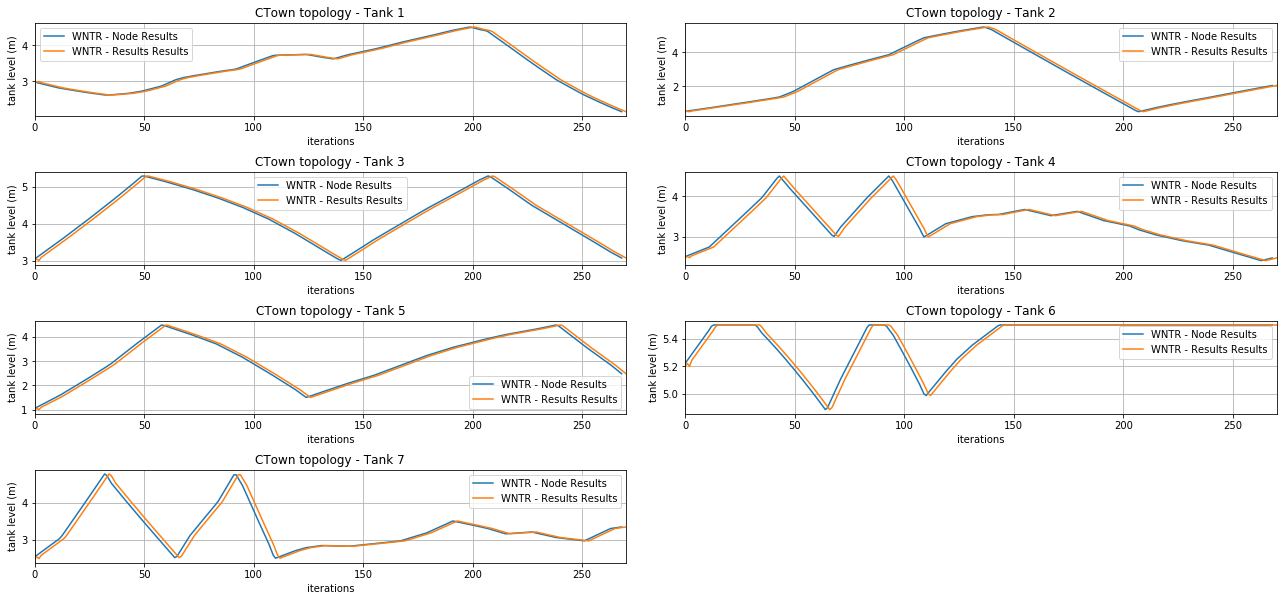

In [12]:
subplot_hspace = 0.6
subplot_wspace = 0.1

dd = plt.subplot(4,2,1)
wntr_ctown_node_results["T1_LEVEL"].plot(label='WNTR - Node Results', ax=dd)
wntr_ctown_resuls_results["T1_LEVEL"].plot(label='WNTR - Results Results', ax=dd)
plt.title("CTown topology - Tank 1")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,2)
wntr_ctown_node_results["T2_LEVEL"].plot(label='WNTR - Node Results', ax=dd)
wntr_ctown_resuls_results["T2_LEVEL"].plot(label='WNTR - Results Results', ax=dd)
plt.title("CTown topology - Tank 2")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,3)
wntr_ctown_node_results["T3_LEVEL"].plot(label='WNTR - Node Results', ax=dd)
wntr_ctown_resuls_results["T3_LEVEL"].plot(label='WNTR - Results Results', ax=dd)
plt.title("CTown topology - Tank 3")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,4)
wntr_ctown_node_results["T4_LEVEL"].plot(label='WNTR - Node Results', ax=dd)
wntr_ctown_resuls_results["T4_LEVEL"].plot(label='WNTR - Results Results', ax=dd)
plt.title("CTown topology - Tank 4")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,5)
wntr_ctown_node_results["T5_LEVEL"].plot(label='WNTR - Node Results', ax=dd)
wntr_ctown_resuls_results["T5_LEVEL"].plot(label='WNTR - Results Results', ax=dd)
plt.title("CTown topology - Tank 5")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,6)
wntr_ctown_node_results["T6_LEVEL"].plot(label='WNTR - Node Results', ax=dd)
wntr_ctown_resuls_results["T6_LEVEL"].plot(label='WNTR - Results Results', ax=dd)
plt.title("CTown topology - Tank 6")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)


dd = plt.subplot(4,2,7)
wntr_ctown_node_results["T7_LEVEL"].plot(label='WNTR - Node Results', ax=dd)
wntr_ctown_resuls_results["T7_LEVEL"].plot(label='WNTR - Results Results', ax=dd)
plt.title("CTown topology - Tank 7")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

In [13]:
def plot_var(tags, data, a_label):
    for var in (tags):
        plt.figure(figsize=(16, 2))    
        plt.plot(data[var], label=a_label)          
        plt.legend()
        plt.grid(True)

        if var in tanks:
            plt.ylabel(var + ' (m)')
        elif var in joints:
            plt.ylabel(var + ' (m)')
        elif var in flows:
            plt.ylabel(var + ' (L/S)')
        else:
            plt.ylabel(var)

        plt.xticks(xlabel_weeks), #plt.xlabel(label_x)
        plt.show()

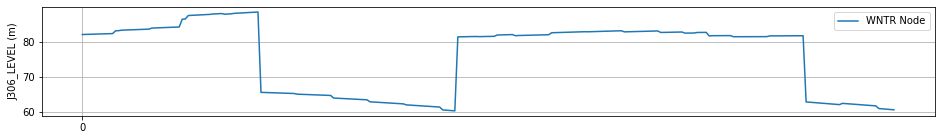

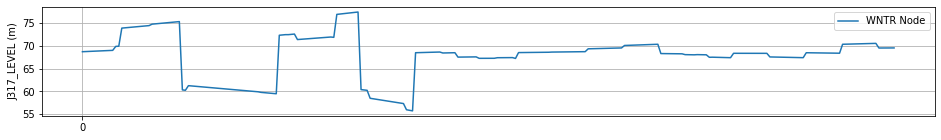

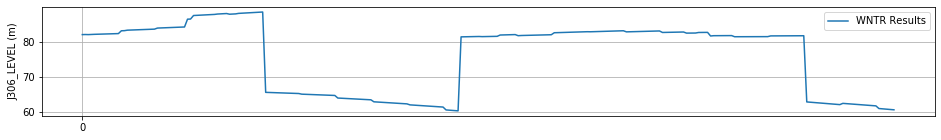

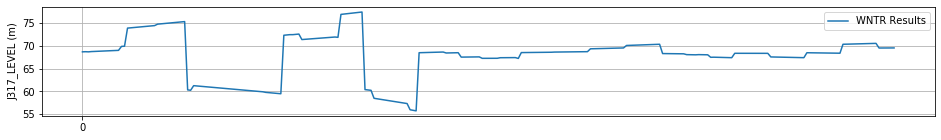

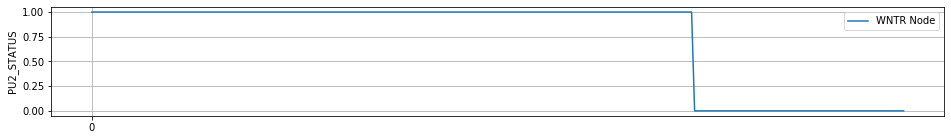

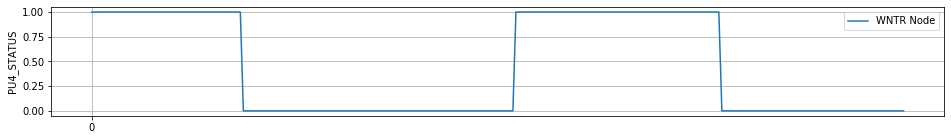

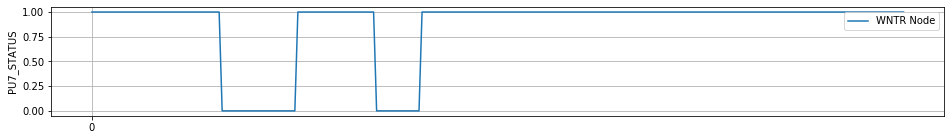

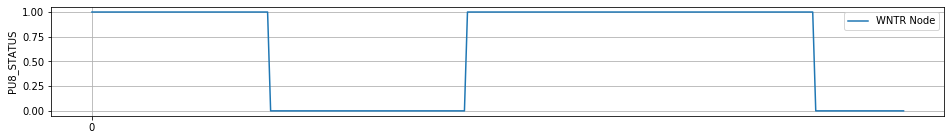

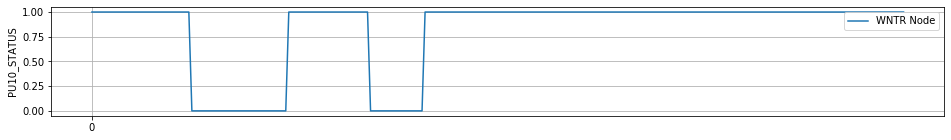

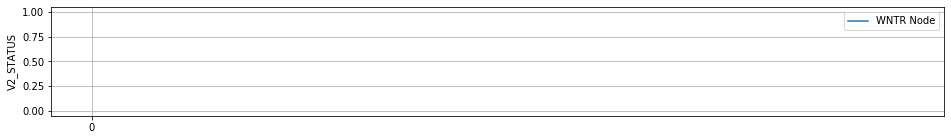

In [16]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'   
    
path_in = 'data/'

sim_weeks = 1

# Data frame creation                
wntr_node_data = wntr_ctown_node_results
wntr_results_data = wntr_ctown_resuls_results

#////////////////////////////// label, cat/non-cat variable definition     ///////////////////////////////

var_all = list(wntr_node_data.head(0))
#var_noncat = ['T1_LEVEL', 'T2_LEVEL', 'T3_LEVEL', 'T4_LEVEL', 'T5_LEVEL', 'T6_LEVEL', 'T7_LEVEL', 
#               'PU1_FLOW', 'PU2_FLOW', 'PU3_FLOW', 'PU4_FLOW', 'PU5_FLOW', 'PU6_FLOW', 'PU7_FLOW',
#               'PU8_FLOW', 'PU9_FLOW', 'PU10_FLOW', 'PU11_FLOW', 
#               'V2_FLOW', 
#               'J280_LEVEL', 'J269_LEVEL', 'J300_LEVEL', 'J256_LEVEL', 'J289_LEVEL', 'J415_LEVEL', 
#               'J302_LEVEL', 'J306_LEVEL', 'J307_LEVEL', 'J317_LEVEL', 'J14_LEVEL', 'J422_LEVEL']      
    
#var_cat =['PU1_STATUS', 'PU2_STATUS', 'PU3_STATUS', 'PU4_STATUS', 'PU5_STATUS', 'PU6_STATUS', 'PU7_STATUS', 'PU8_STATUS',
#          'PU9_STATUS','PU10_STATUS', 'PU11_STATUS',
#          'V2_STATUS'] 

#var_cat_noncat = var_noncat + var_cat
var_cat_noncat =['J306_LEVEL', 'J317_LEVEL']

tanks = ['T1_LEVEL', 'T2_LEVEL', 'T3_LEVEL', 'T4_LEVEL', 'T5_LEVEL', 'T6_LEVEL', 'T7_LEVEL']

joints = ['J280_LEVEL', 'J269_LEVEL', 'J300_LEVEL', 'J256_LEVEL', 'J289_LEVEL', 'J415_LEVEL',
          'J302_LEVEL', 'J306_LEVEL', 'J307_LEVEL', 'J317_LEVEL', 'J14_LEVEL', 'J422_LEVEL']

flows = ['PU1_FLOW', 'PU2_FLOW', 'PU3_FLOW', 'PU4_FLOW', 'PU5_FLOW', 'PU6_FLOW', 
         'PU7_FLOW', 'PU8_FLOW', 'PU9_FLOW', 'PU10_FLOW', 'PU11_FLOW',
         'V2_FLOW']

status = ['PU2_STATUS', 'PU4_STATUS', 'PU7_STATUS', 'PU8_STATUS', 'PU10_STATUS','V2_STATUS']

xlabel_weeks = np.linspace(0, len(wntr_node_data), sim_weeks)

# Junctions J306 and J317 with 1 minute hydraulic timestep
plot_var(var_cat_noncat, wntr_node_data, "WNTR Node")

# Junctions J306 and J317 with 2 minute hydraulic timestep
plot_var(var_cat_noncat, wntr_results_data, "WNTR Results")

# Pump and valve statuses with 5 minute hydraulic timestep
plot_var(status, wntr_node_data, "WNTR Node")